In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.linalg as sp
import torch as th

import os, pdb, sys, json, glob, tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from itertools import product
import torch.nn.functional as F

sns.set_style('whitegrid')

sns.set_context('notebook')

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 200

dev = 'cuda'

In [3]:
from utils import *
from embed import *
from tqdm import tqdm
from distance import *
models = ["wr-4-8", "allcnn-96-144", "fc-1024-512-256-128"]
opts = ["adam", "sgdn", "sgd"]

In [ ]:
loc = 'results/models/new'
d = load_d(loc, cond={'aug': [True], 'm': models, 'opt':opts, 'wd':[0.0], 'bn':[True], 'bs':[200], },
        avg_err=True, drop=0.0, probs=True, verbose=False)

### Project onto uniform-->target geodesic

In [ ]:
yhs = np.sqrt(np.stack(d['yh'].values))
ps = np.sqrt(np.ones_like(yhs) / 10)
ds = get_data()['train']
y_ = np.array(ds.targets, dtype=np.int32)
y = np.zeros((y_.size, y_.max()+1))
y[np.arange(y_.size), y_] = 1
qs = np.sqrt(np.repeat(np.expand_dims(y, axis=0), yhs.shape[0], axis=0))

In [ ]:
def projection(r, p, q, debug=False, mode='prod'):
    # r, p, q shape (nmodels, nsamples, nclasses)
    if debug:
        assert np.allclose([(r**2).sum(-1), (p**2).sum(-1), (q**2).sum(-1)], 1)
    cost, cost1, cost2 = (p*q).sum(-1, keepdims=True), (p*r).sum(-1, keepdims=True), (q*r).sum(-1, keepdims=True)
    if mode == 'prod':
        ti = np.arccos(cost)
        d = lambda t: np.arccos(cost1*np.sin((1-t)*ti)/np.sin(ti) + cost2* np.sin(t*ti)/np.sin(ti)).sum(1)
        d0 = d(0)
        lams = np.linspace(0, 1, 100)
        lam = np.zeros([ti.shape[0], 1])
        for (i, dt) in tqdm(enumerate(map(d, lams))):
            lam[dt < d0] = lams[i]
            d0 = dt
    elif mode == 'mean':
        tan = cost2/(cost1*np.sqrt(1-cost**2)) - cost / np.sqrt(1-cost**2)
        lam = (np.arctan(tan) * (tan > 0)) / np.arccos(cost)
        lam[lam > 1] = 1
    return lam

In [ ]:
lam = projection(yhs, ps, qs, True)
d['lam'] = lam

In [ ]:
th.save(d, os.path.join(loc, 'all_with_lam.p'))

In [ ]:
d_ = d.iloc[get_idx(d,"seed==42")]
sns.lineplot(data=d_, x='t', y='lam', hue='m', style='opt', markers=True)

In [ ]:
lams = projection((yhs).reshape(-1, 10), ps.reshape(-1, 10), qs.reshape(-1, 10), True, mode='mean')
lams = lams.reshape(1800, -1)
d['lams'] = lams.mean(1)
d['std'] = np.std(lams, axis=1)
d_ = d.iloc[get_idx(d,"seed==42")]

In [ ]:
idxs = d_.groupby(['m', 'opt']).indices
for config in idxs.keys():
    idx = idxs[config]
    di = d_.iloc[idx]
    plt.plot(di['t'], di['lams'], '.-', label=str(config))
    plt.fill_between(di['t'], di['lams'] - di['std'], di['lams'] + di['std'], alpha=0.3)
plt.legend()

### Project from uniform-->target to trajectory

In [10]:
loc = 'results/distances'

<AxesSubplot:xlabel='t', ylabel='lam'>

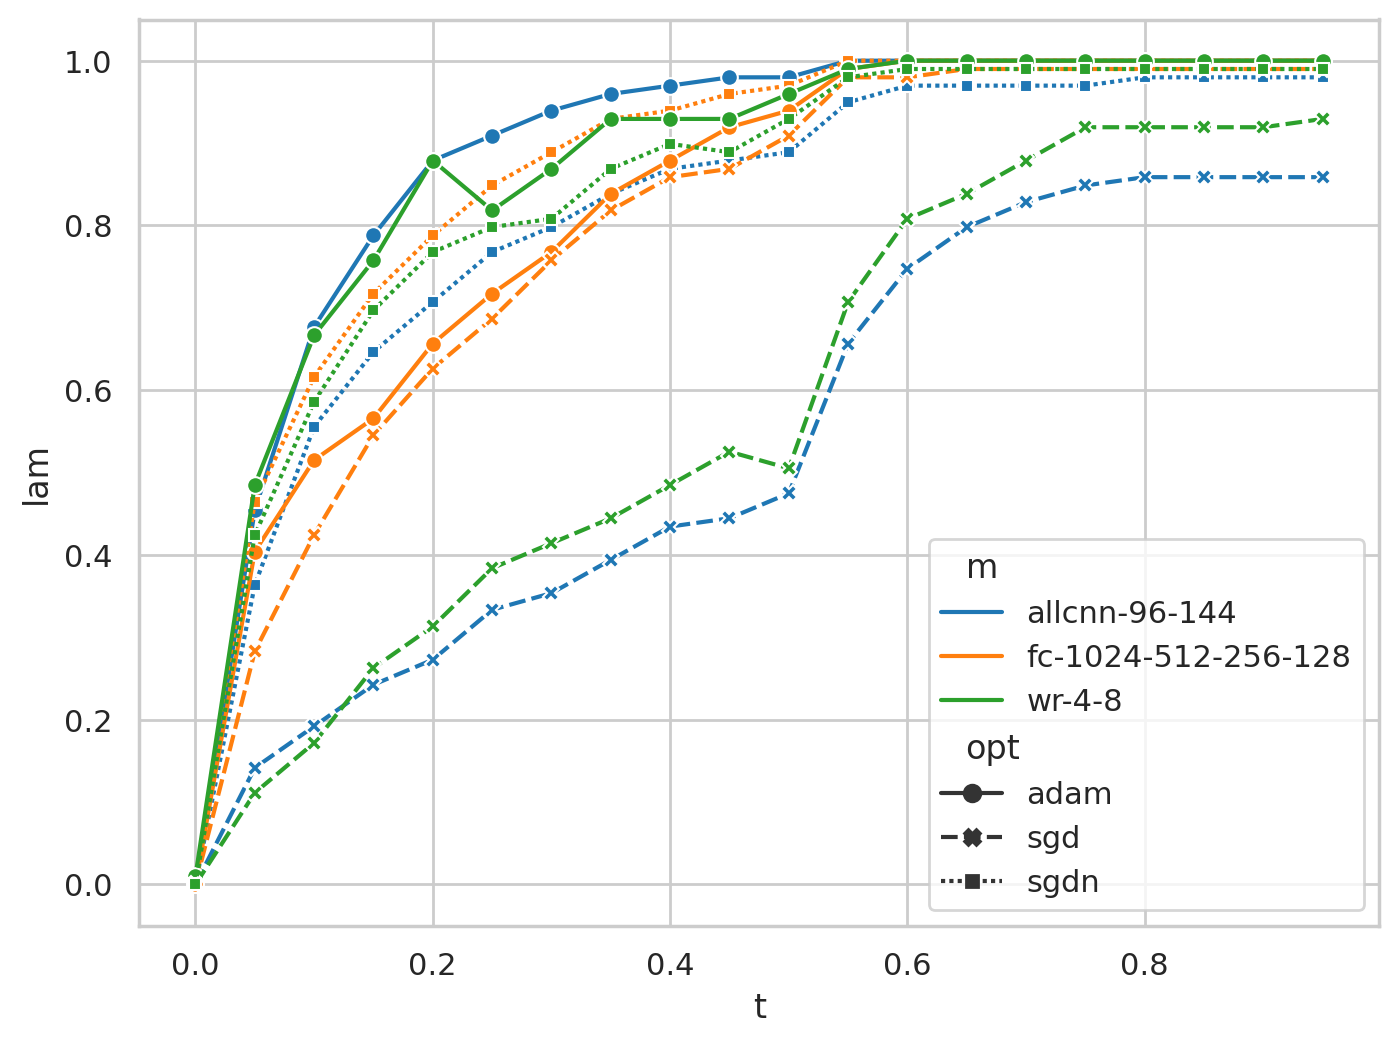

In [73]:
sns.lineplot(data=d[d['seed'] == 42], x='t', y='lam', hue='m', style='opt', markers=True)

In [ ]:
def projection(r, p, q, debug=False, mode='prod'):
    # r, p, q shape (nmodels, nsamples, nclasses)
    nm, ns, nc = r.shape
    if debug:
        assert np.allclose([(r**2).sum(-1), (p**2).sum(-1), (q**2).sum(-1)], 1)
    cost, cost1, cost2 = (p*q).sum(-1, keepdims=True), (p*r).sum(-1, keepdims=True), (q*r).sum(-1, keepdims=True)
    if mode == 'prod':
        if cost.max() > 1 or cost.min()<0:
            cost[cost> 1] = 1
            cost[cost< 0] = 0
        ti = np.arccos(cost)
        d1 = np.arccos(cost1[ti == 0]).sum()
        cost1, cost2 = cost1[ti > 0], cost2[ti > 0]
        ti = ti[ti > 0]

        def d(t): 
            coss = cost1*np.sin((1-t)*ti) / np.sin(ti) + cost2 * np.sin(t*ti)/np.sin(ti)
            if coss.max() > 1 or coss.min() < 0:
                coss[coss > 1] = 1
                coss[coss < 0] = 0
            return d1 + np.arccos(coss).sum()
        d0 = d(0)
        lams = np.linspace(0, 1, 100)
        lam = np.zeros([nm, 1])
        for (i, dt) in enumerate(map(d, lams)):
            lam[dt < d0] = lams[i]
            d0 = dt
    elif mode == 'mean':
        tan = cost2/(cost1*np.sqrt(1-cost**2)) - cost / np.sqrt(1-cost**2)
        lam = (np.arctan(tan) * (tan > 0)) / np.arccos(cost)
        lam[lam > 1] = 1
    return lam


In [ ]:
def gamma(t, p, q):
    # p, q shape: nmodels, nsamples, nclasses
    cospq = (p*q).sum(-1)
    if cospq.max() > 1 or cospq.min() < 0: 
        cospq[cospq > 1] = 1
        cospq[cospq < 0] = 0
    ti = np.arccos(cospq)
    mask = ti==0
    gamma = np.zeros_like(p)
    gamma[mask, :] = p[mask, :]
    p, q = p[~mask, :], q[~mask, :]
    ti = ti[~mask, None]
    gamma[~mask, :] = np.sin((1-t)*ti) / np.sin(ti) * \
        p + np.sin(t*ti) / np.sin(ti) * q
    return gamma


In [ ]:
ps = np.sqrt(np.ones([1, 50000, 10]) / 10)
ds = get_data()['train']
y_ = np.array(ds.targets, dtype=np.int32)
y = np.zeros((y_.size, y_.max()+1))
y[np.arange(y_.size), y_] = 1
qs = np.expand_dims(y, axis=0) 

In [ ]:
new_avg = []
groups = ['m', 'opt', 'seed']
configs = d.groupby(groups).indices
ts = np.linspace(0, 1, 51)[1:]
for (c, idx) in configs.items():
    di = d.iloc[idx]
    for t in ts:
        data = {groups[i]:c[i] for i in range(len(c))}
        data['t'] = t
        k1 = di[di['lam'] >= t]['t']
        k2 = di[di['lam'] < t]['t']
        ks = set(k2.index).intersection(set(k1.index-1)).intersection(set(di.index[:-1]))
        if len(ks) == 0:
            # continue
            ks = set(di.index[-1:]-1)
        diff = 1
        for k in ks:
            p = np.sqrt(di.loc[k]['yh'])[None, :]
            q = np.sqrt(di.loc[k+1]['yh'])[None, :]
            r = gamma(t, ps, qs)
            lam = projection(r, p, q)
            if abs(lam-0.5) < diff:
                diff = abs(lam-0.5)
                data['yh'] = (gamma(lam, p, q) ** 2).squeeze()
                data['err'] = (np.argmax(data['yh'], axis=-1) != y_).mean()
                data['favg'] = -np.log(data['yh'])[:, np.arange(len(y_)), y_].mean()
        # data['yh'] = gamma(lam, p, q)
        print(c, t, k, lam, data['err'], data['favg'])
        new_avg.append(data)


In [ ]:
df = pd.DataFrame(new_avg)

In [ ]:
df['yh'] = df.apply(lambda r: r.yh.squeeze(), axis=1)

In [ ]:
th.save(df, os.path.join(loc, 'new_avg.p'))

In [ ]:
avg = avg_model(df, groupby=['m', 'opt', 't'], probs=True, get_err=True, update_d=True, compute_distance=False, dev='cuda', keys=['yh'])['d']
dists, configs = pairwise_dist_batch(avg, groups=['m', 'opt', 'seed'], s=0.0, batch=2, sym='mean', normalization='length')

In [ ]:
symd = dists
symd[np.tril_indices(len(dists), -1)] = 0
symd = symd + symd.T

In [ ]:
th.save({'dists': dists, 'symd': symd, 'configs': configs, 'groups': ['m', 'opt'] + ['seed']},
        os.path.join(loc, f'new_avg_0.0_mean_length.p'))


In [ ]:
sns.lineplot(data=df, x='t', y='err', hue='m', style='opt', markers=True)

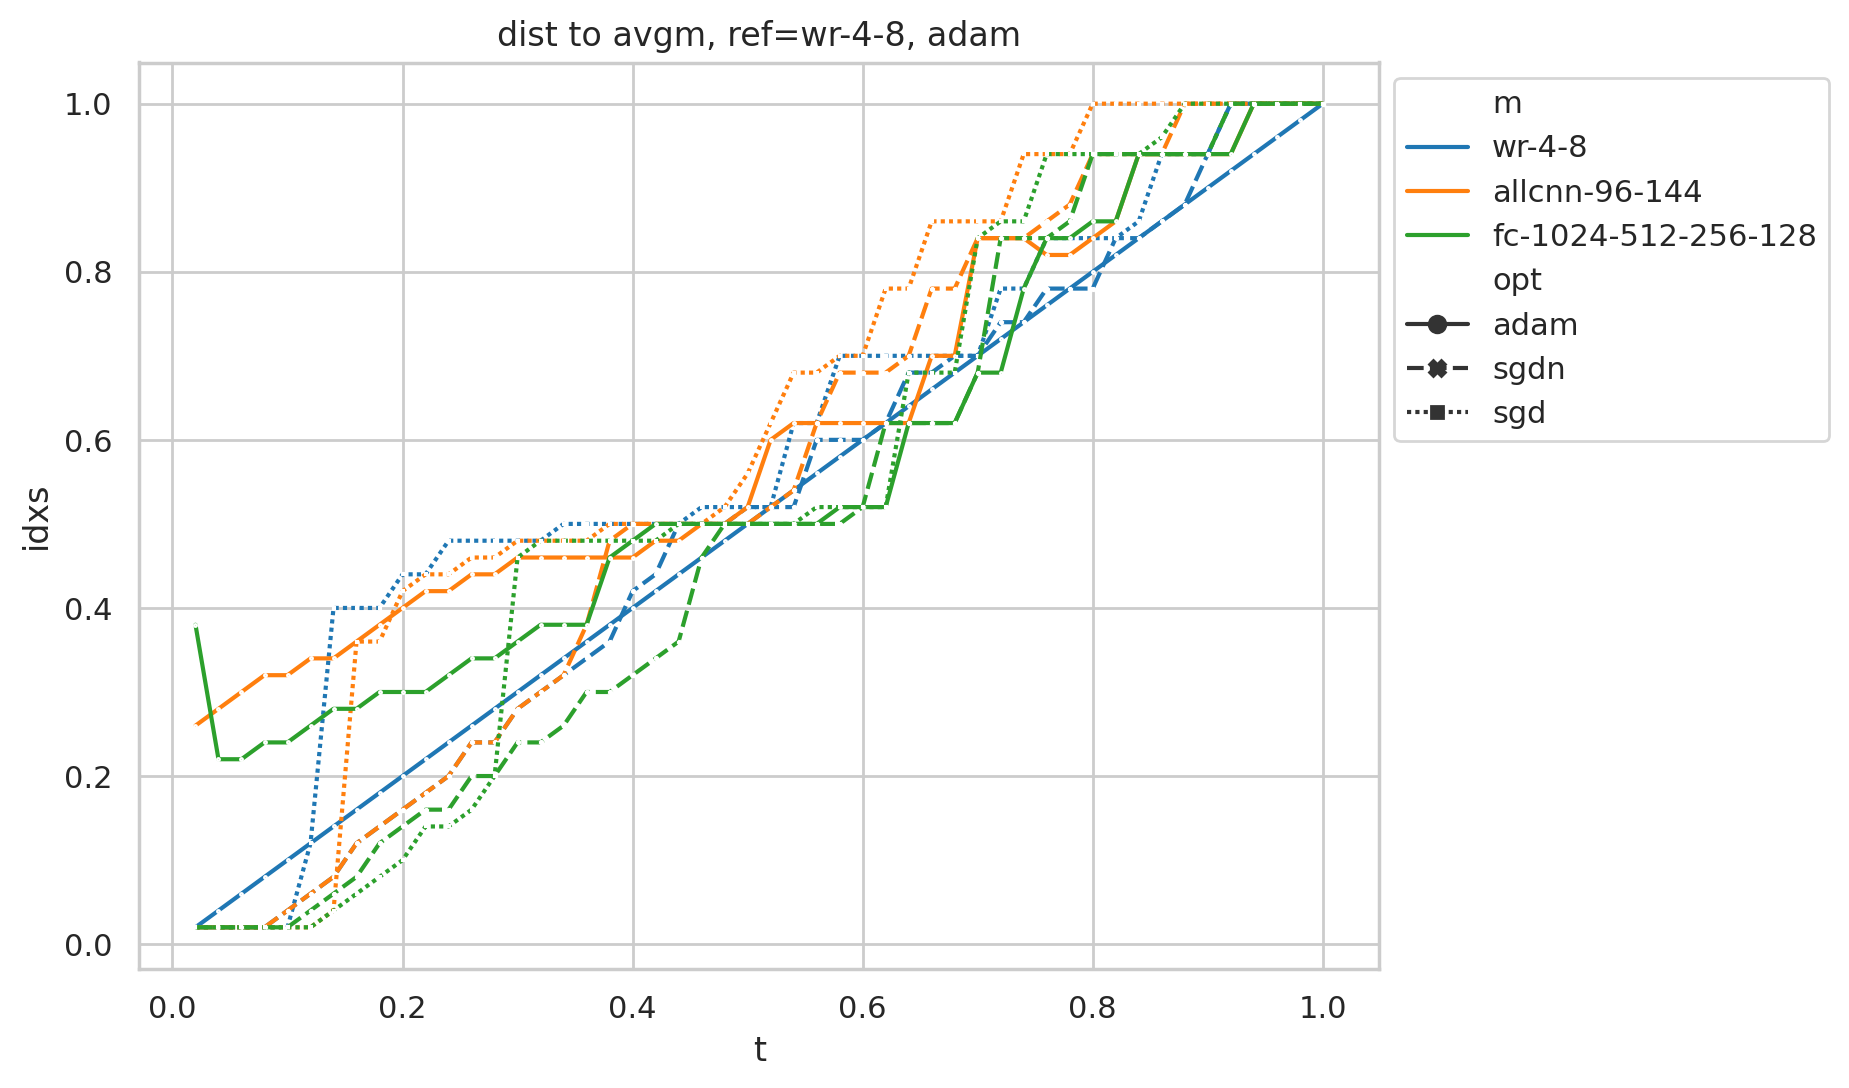

In [70]:
# avg = avg_model(df, groupby=['m', 'opt', 't'], probs=True, get_err=True, update_d=True, compute_distance=False, dev='cuda', keys=['yh'], distf=dbhat)['d']
dists = []
k = 'yh'
d = avg
tidxs = avg['t'].unique()
ref= get_idx(d, f"m=='{models[0]}' & opt=='{opts[0]}'& avg==True")
for o in opts:
    for m in models:
        i2 = get_idx(d, f"m=='{m}' & opt=='{o}' & avg==True")
        kdist, idxs = dp2t(th.Tensor(np.stack(d.iloc[i2][k].values)), 
                        th.Tensor(np.stack(d.iloc[ref][k].values)), s=0.0, return_idxs=True)
        for i in range(len(kdist)):
            dists.append(dict(dist=kdist[i].item(), m=m, opt=o, 
                                t=tidxs[i], key=k, seed=seed, idxs=tidxs[idxs[i].item()]))
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists, x='t', y='idxs', hue='m', style='opt', markers=True, markersize=1)
ax.set_title(f'dist to avgm, ref={models[0]}, {opts[0]}')
plt.legend(bbox_to_anchor=(1, 1), loc=2)

In [8]:
df = th.load(os.path.join(loc,  'new_avg.p'))

In [18]:
df['yh'] = df.apply(lambda r: r.yh.reshape(-1, 10), axis=1)

<AxesSubplot:xlabel='t', ylabel='dist'>

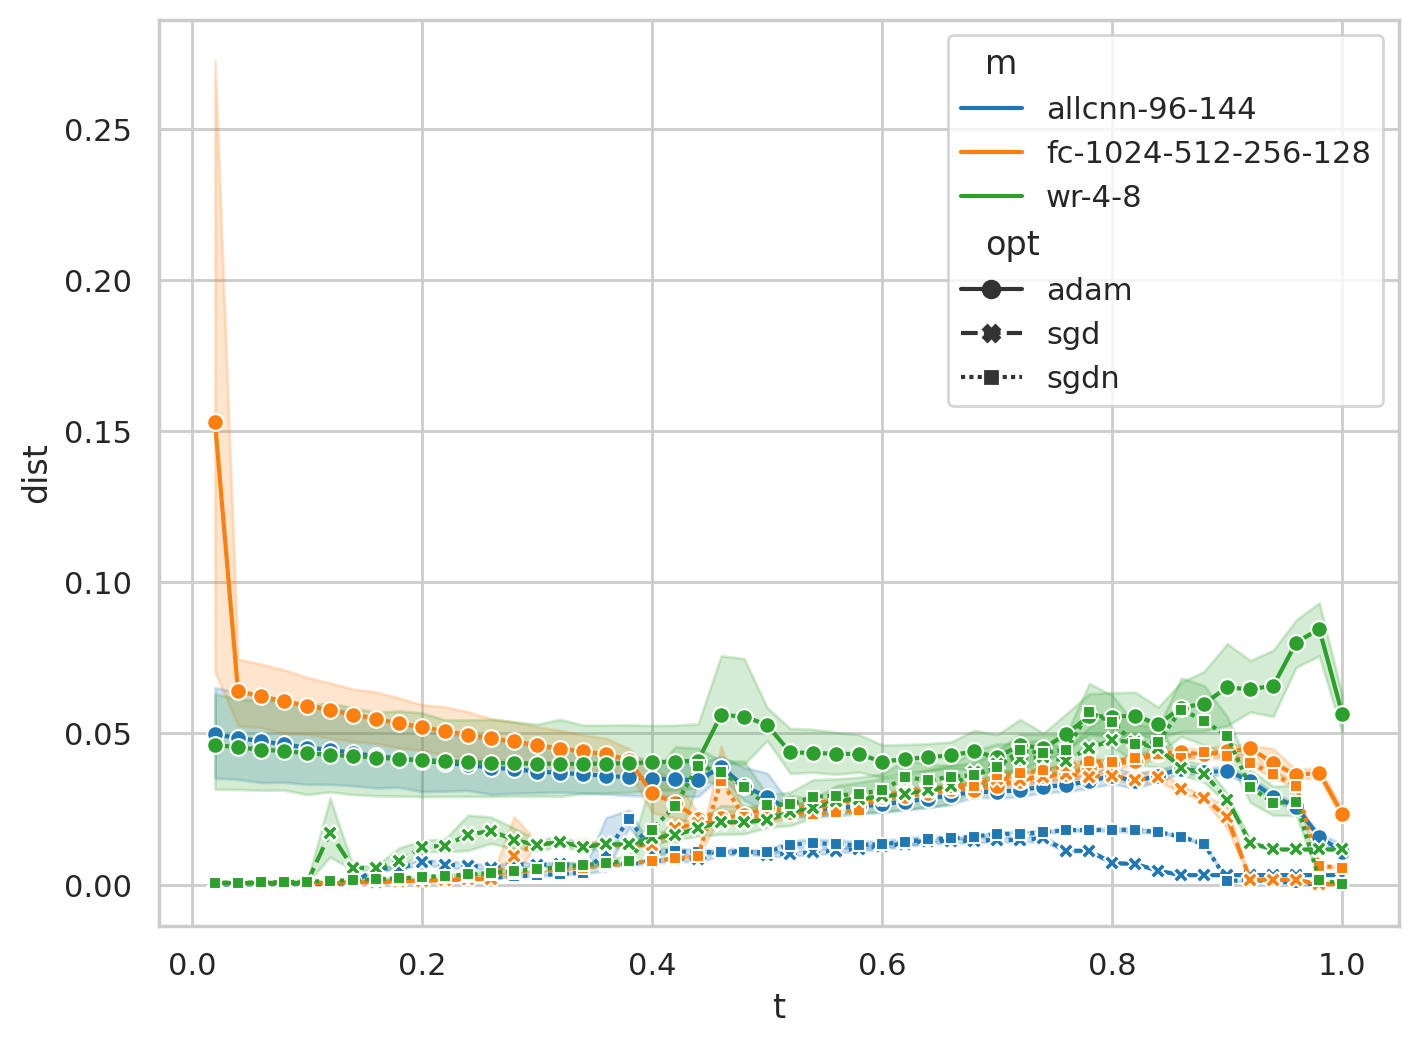

In [20]:
from functools import partial
avg = avg_model(df, groupby=['m', 'opt', 't'], probs=True, get_err=True, update_d=True,
                compute_distance=True, dev='cuda', keys=['yh'], distf=partial(dbhat,debug=True))
sns.lineplot(data=avg['dists'], x='t', y='dist', hue='m', style='opt', markers=True)

### slices of the tube

In [5]:
loc = 'results/distances/'
d = th.load(os.path.join(loc, 'new_avg.p'))
d['yh'] = d.apply(lambda r: r.yh.squeeze(), axis=1)
avg = avg_model(d, groupby=['m', 'opt', 't'], probs=True, get_err=True, update_d=True, compute_distance=False, dev='cuda', keys=['yh'])['d']

In [6]:
avg['t'].unique()

array([0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22,
       0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42, 0.44,
       0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64, 0.66,
       0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86, 0.88,
       0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])

In [7]:
data = []
scatters = []
for t in avg['t'].unique():
    xt = avg.iloc[get_idx(avg, f"t == {t} & seed > 0")]
    xt_avg = avg.iloc[get_idx(avg, f"t == {t} & seed < 0")]
    xs = th.tensor(np.stack(xt['yh']))
    xs_avg = th.tensor(np.stack(xt_avg['yh']))
    w = dbhat(xs, xs, chunks=20)
    d_mean = w.mean(0)
    l = np.eye(w.shape[0]) - 1.0/w.shape[0]
    w = -l @ w @ l / 2 
    r = proj_(w, len(xs), len(xs)//2-1)
    e = sorted(np.log(np.abs(r['e'])))[:0:-1]
    for x in range(len(e)-1):
        data.append(dict(x=x, y=e[x], t=t))
        scatters.append({f'x{j}':r['xp'][x, j] for j in range(r['xp'].shape[1])})
        scatters[-1].update({f'e{j}':r['e'][j] for j in range(r['xp'].shape[1])})
        scatters[-1].update(dict(t=t, 
                             avg=False, config=(xt.iloc[x]['m'],xt.iloc[x]['opt'])))
    q = lazy_embed(xs_avg, xs, w, d_mean, r['e'], r['v'], ne= len(xs)//2-1)
    for i in range(len(q)):
        scatters.append({f'x{j}':q[i, j] for j in range(q.shape[1])})
        scatters[-1].update(dict(t=t, avg=True, config=(xt_avg.iloc[i]['m'],xt_avg.iloc[i]['opt'])))
        scatters[-1].update({f'e{j}':r['e'][j] for j in range(r['xp'].shape[1])})
data = pd.DataFrame(data)

100%|█████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 15.73it/s]


Projecting


100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 94.89it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.86it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.78it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.63it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.74it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 405.16it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.70it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.94it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.29it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 405.03it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.78it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.97it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.89it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.89it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.93it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 405.09it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.90it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 405.17it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.77it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.90it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.80it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.97it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.96it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.89it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.59it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 405.00it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.80it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.65it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.60it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 405.04it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.75it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.89it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.87it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.96it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.93it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 405.04it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.81it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 405.16it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.98it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 405.38it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.81it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.85it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.72it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.66it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.93it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 405.01it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.85it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.65it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.80it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.70it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.90it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.94it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.79it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.80it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.78it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 405.38it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.80it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.59it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.83it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.76it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.81it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.96it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.84it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 405.12it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.85it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.78it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.77it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.78it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.75it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.78it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.86it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 405.05it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.81it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.97it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.86it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 405.31it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.87it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.57it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.78it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 405.21it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.89it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.86it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.80it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.81it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.80it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.81it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.75it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.88it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.93it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.82it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.76it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 403.01it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.79it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 405.16it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.85it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.33it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.79it/s]


Projecting


100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 404.50it/s]


Projecting


100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.89it/s]


Projecting


<AxesSubplot:xlabel='x', ylabel='y'>

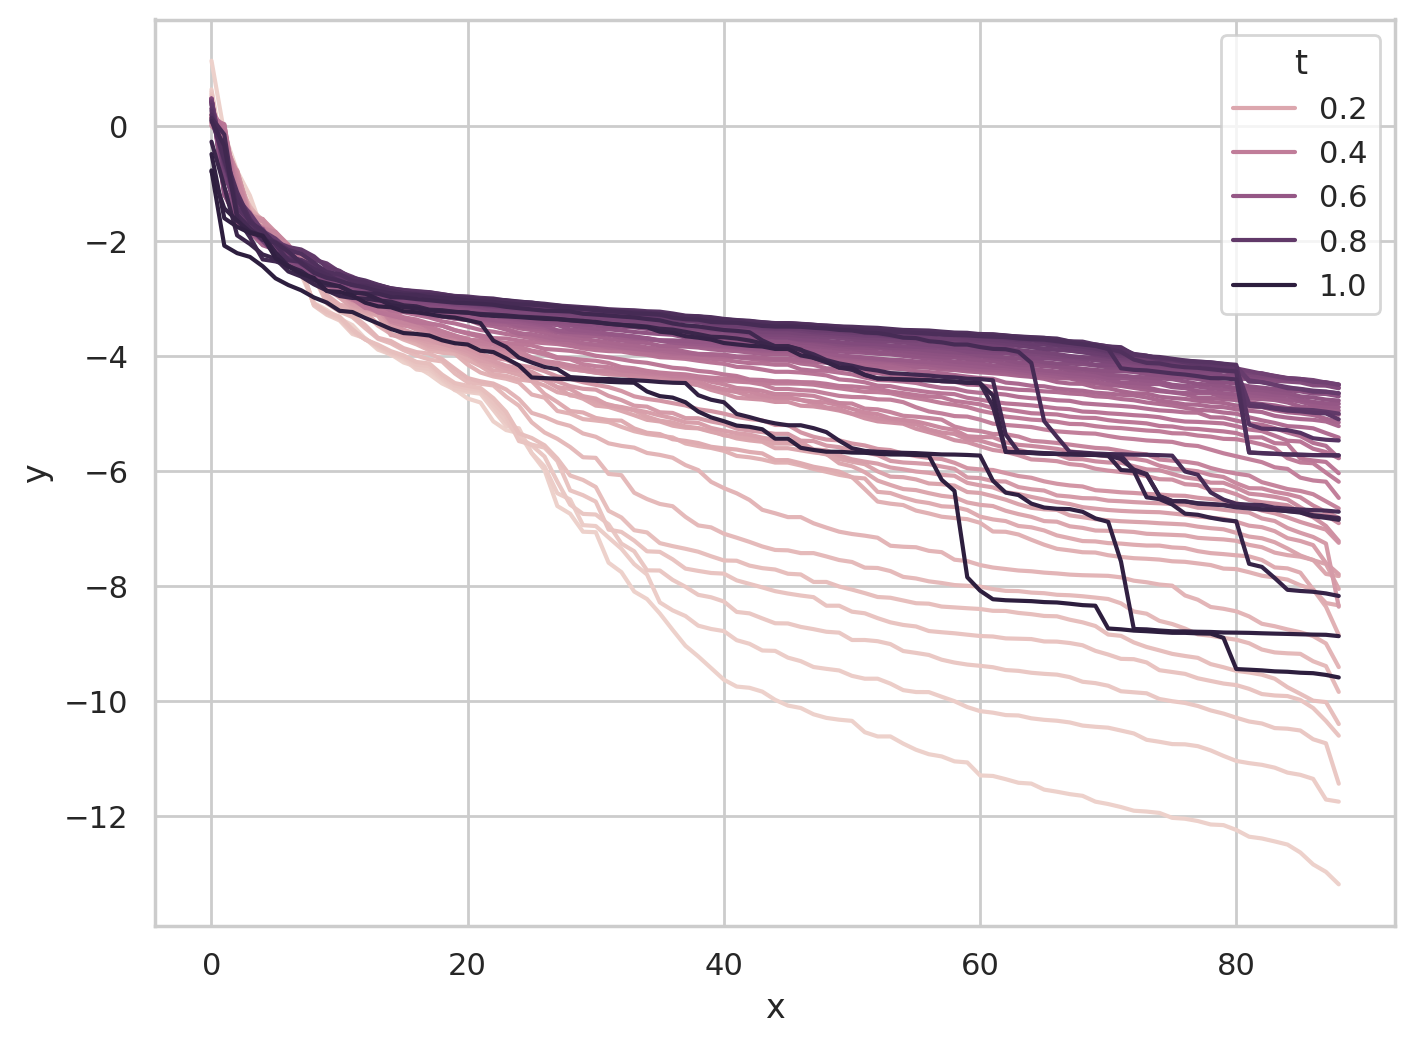

In [8]:
sns.lineplot(data=data, x='x', y='y', hue='t', markers=True)

In [9]:
scatters = pd.DataFrame(scatters)

In [22]:
scatters['x90']

0      -1.688946e-09
1      -1.688946e-09
2      -1.688946e-09
3      -1.688946e-09
4      -1.688946e-09
            ...     
4895    4.424399e+06
4896    4.832143e+06
4897   -1.113550e+07
4898   -9.563813e+06
4899    5.886598e+06
Name: x90, Length: 4900, dtype: float64

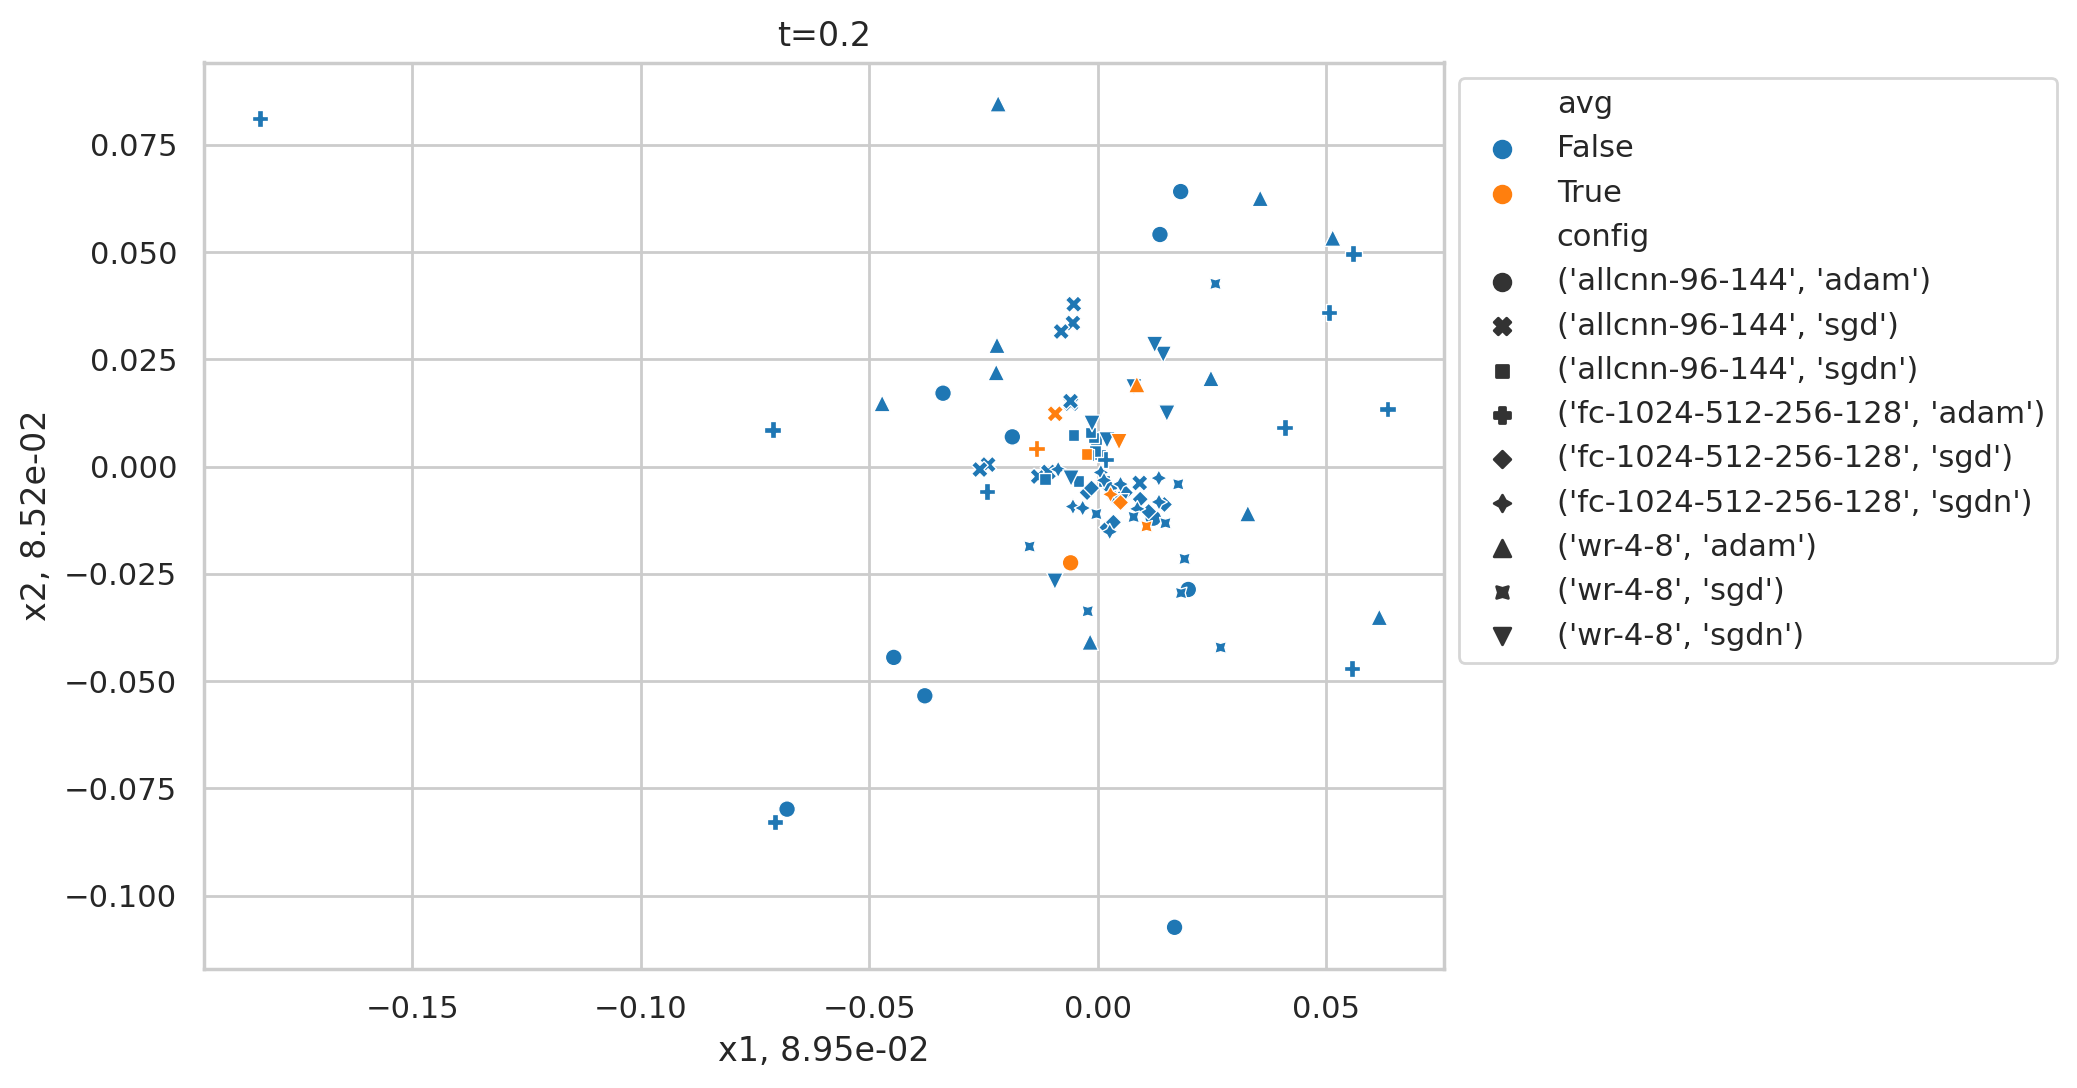

In [33]:
t = 0.2
x = 7
y = 8
ax=sns.scatterplot(data=scatters[scatters['t'] == t], x=f'x{x}', y=f'x{y}', hue='avg', style='config')
ax.set(xlabel=f"x1, {(scatters[scatters['t'] == t][f'e{x}'].iloc[0]):.2e}", 
       ylabel=f"x2, {(scatters[scatters['t'] == t][f'e{y}'].iloc[0]):.2e}")
ax.set_title(f't={t}')
ax.legend(bbox_to_anchor=(1, 1), loc=2)